# Маркетинговая аналитика Яндекс.Афиши

В нашем распоряжении данные с июня 2017 по конец мая 2018 года: лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов. Необходимо определить невыгодные источники трафика и перераспределить бюджет.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Обработка данных

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('/datasets/costs.csv')

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Есть столбцы с датами, но без соотвествующего типа, исправляем:

In [6]:
visits['End Ts']=pd.to_datetime(visits['End Ts'])
visits['Start Ts']=pd.to_datetime(visits['Start Ts'])

In [7]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [8]:
visits=visits[visits['End Ts'] >= visits['Start Ts']]

In [9]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 5 columns):
Device       359398 non-null object
End Ts       359398 non-null datetime64[ns]
Source Id    359398 non-null int64
Start Ts     359398 non-null datetime64[ns]
Uid          359398 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 16.5+ MB


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Проводим аналогичные действия с двумя оставшимися таблицами:

In [11]:
orders['Buy Ts']=pd.to_datetime(orders['Buy Ts'])

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [13]:
costs['dt']=pd.to_datetime(costs['dt'])

Посмотрим описательную статистику выручки и затрат:

In [14]:
orders['Revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

Отмечаем, что максимальная сумма выручки в таблице аномально высокая: 2633 у.е.

In [15]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Максимальные затраты также существенно выбиваются из среднего показател расходов, максимально за рассматриваемый период было затрачено 1788,28 у.е.

## Расчет метрик

### Продуктовые метрики

#### DAU, WAU, MAU

Создаем в таблице с посещениями сайта столбцы с годом, месяцем, неделей, датой посещения:

In [16]:
visits['year'] = visits['Start Ts'].dt.year
visits['month'] = visits['Start Ts'].astype('datetime64[M]')
visits['date'] = visits['Start Ts'].astype('datetime64[D]')
visits['week'] = visits['Start Ts'].astype('datetime64[W]')

Переходим к расчету метрик. Первым посчитаем DAU - количество уникальных пользователей. Группируем таблицу посещений по дате и считаем для каждой группы количество уникальных пользователей, а затем выводим среднее, это будет общий показаель DAU за рассматриваемый период. Аналогично делаем для расчет WAU(количество уникальных пользователей за неделю) и MAU (количество уникальных пользователей за месяц).

In [17]:
dau_total = visits.groupby('date').agg({'Uid': 'nunique'}).mean()
dau_total

Uid    907.991758
dtype: float64

In [18]:
wau_total = visits.groupby(['year', 'week']).agg({'Uid': 'nunique'}).mean()
wau_total

Uid    5621.703704
dtype: float64

In [19]:
mau_total = visits.groupby(['year', 'month']).agg({'Uid': 'nunique'}).mean()
mau_total

Uid    23228.416667
dtype: float64

Посчитаем метрики по каждому периоду и визуализируем через простой график.

In [20]:
dau = visits.groupby('date').agg({'Uid': 'nunique'}).reset_index()
wau = visits.groupby(['year', 'week']).agg({'Uid': 'nunique'}).reset_index()
mau = visits.groupby(['year', 'month']).agg({'Uid': 'nunique'}).reset_index()

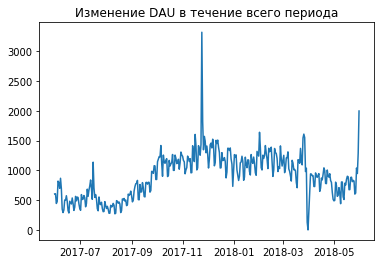

In [21]:
fig, ax = plt.subplots()
ax.plot(dau['date'], dau['Uid'])
plt.title('Изменение DAU в течение всего периода')
plt.show()

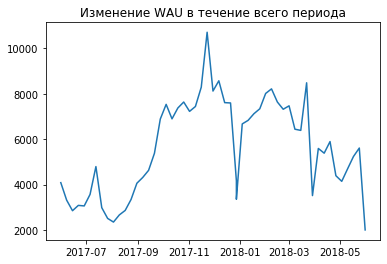

In [22]:
fig, ax = plt.subplots()
ax.plot(wau['week'], wau['Uid'])
plt.title('Изменение WAU в течение всего периода')
plt.show()

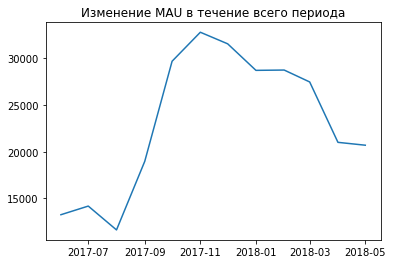

In [23]:
fig, ax = plt.subplots()
ax.plot(mau['month'], mau['Uid'])
plt.title('Изменение MAU в течение всего периода')
plt.show()

Можем заметить резкий скачок всех трех метрик в ноябре 2017 года. При этом кол-во пользователей в разбивке по неделям сильно упало в конце декабря, но затем восстановилось. В среднем на сайт заходит чуть меньше 1000 человек в день.

#### Количество посещений на пользователя

Посмотрим, сколько раз уникальный пользователь в среднем заходит на сайт.
Группируем таблицу с посещениями по дате, считаем количество пользователей, зашедших на сайт (количество посещений общее) и количество уникальных пользователей. Делим колисетво посещений на количество уникальных пользователей. И строим график.

In [24]:
sessions_per_user = visits.groupby('date').agg({'Uid':['count', 'nunique']}).reset_index()
sessions_per_user.columns = ['date','n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions']/sessions_per_user['n_users']

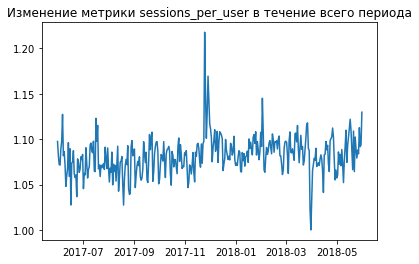

In [25]:
fig, ax = plt.subplots()
ax.plot(sessions_per_user['date'], sessions_per_user['sess_per_user'])
plt.title('Изменение метрики sessions_per_user в течение всего периода')
plt.show()

В целом уникальный пользователь заходит на сайт раз в сутки, при этом на графике этой метрики также замечаем скачок в ноябре 2017.

#### Продолжительность сессии

Посмотрим, сколько времени пользователи проводят на сайте. Добавляем в таблицу с посещениями столбец с длительностью сессии в секундах через расчет разницы конца сессии и ее начала. А затем строим гистрогамму распредления длительности.

In [26]:
visits['session_duration_sec'] = (visits['End Ts'] - visits['Start Ts']).dt.seconds

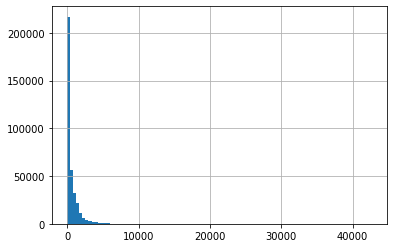

In [27]:
visits['session_duration_sec'].hist(bins=100)
plt.show()

Распредление сильно отлично от нормального, поэтому для расчета среднего времени сессии лучше использовать моду:

In [28]:
asl = visits['session_duration_sec'].mode()
asl

0    60
dtype: int64

Среднее время посещения сайта 60 секунд.

#### Retention Rate

Расчитаем Retention Rate - какое количество пользователей осталось с нами по отношению к изначальному количеству.
Создаем отдельную таблицу, где для каждого пользователя указываем первую дату посещения сайта. Присоединяем полученную таблицу к первой таблице с посещениями.

In [29]:
first_activity_date = visits.groupby(['Uid'])['Start Ts'].min()
first_activity_date.name = 'first_activity_date'
visits_df = visits.join(first_activity_date, on='Uid')
visits_df['first_activity_month'] = visits_df['first_activity_date'].astype('datetime64[M]')
visits_df.head()

,Device,End Ts,Source Id,Start Ts,Uid,year,month,date,week,session_duration_sec,first_activity_date,first_activity_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-20,2017-12-14,1080,2017-12-20 17:20:00,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-19,2018-02-15,1680,2018-02-19 16:53:00,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-07-01,2017-06-29,0,2017-07-01 01:54:00,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-20,2018-05-17,1440,2018-03-09 20:05:00,2018-03-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-27,2017-12-21,0,2017-12-27 14:06:00,2017-12-01


Теперь у нас есть все необходимое для создания таблицы с когортами, строить их будем по месяцам, в пред.шаге мы создали доп.столбец с месцем первой активности для каждого пользователя. Делаем сводную, где в строках указываем месяц первой активности на сайте, в столбцах месяц посещения, в значениях указываем уникальное кол-во посетителей.

In [30]:
cohort = visits_df.pivot_table(index='first_activity_month',
                               columns='month',
                               values='Uid',
                               aggfunc='nunique').reset_index()
cohort

month,first_activity_month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00
0,2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
1,2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2,2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
3,2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
4,2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
5,2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
6,2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
7,2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
8,2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0
9,2018-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20589.0,861.0,557.0


Видим, что с октября 2017 количество новых пользователей увеличилось, если в сентябре к нам пришло 16704 человек, то в ноябре 25977. В апреле-мае 2018 этот показатель существенно падает до 15709 и 15273 человек в месяц. Также отмечаем, что во всех когортах число поставшихся пользователей очень сильно падает из месяца в месяц. И снова замечаем, что в ноябре 2017 кол-во новых пользователей самое высокое.

Добавим в таблицу с посещениями длительность "жизни" когорты, для нас этот показатель будет означать, в каком по счету месяце от месяца когорты произошло событие.

In [31]:
visits_df['lifetime'] = visits_df['month'] - visits_df['first_activity_month']
visits_df['lifetime'] = visits_df['lifetime']/np.timedelta64(1, 'M')
visits_df['lifetime']= visits_df['lifetime'].round().astype('int')


Теперь строим группировку, где в каждой когорте делаем разбивку по месяцам событий и считаем кол-во уникальных пользователей в месяц этого события.

In [32]:
cohorts_lifetime = visits_df.groupby(['first_activity_month', 'lifetime']).agg({'Uid':'nunique'}).reset_index()
cohorts_lifetime

,first_activity_month,lifetime,Uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
...,...,...,...
73,2018-03-01,1,861
74,2018-03-01,2,557
75,2018-04-01,0,15709
76,2018-04-01,1,760


Оставляем в сгруппированной таблице данные только по первому посещению, т.е. у нас получается таблица с месяцем первой активности и кол-ву уникальных пользователей в каждом таком месяце.

In [33]:
initial_users_count = cohorts_lifetime[cohorts_lifetime['lifetime'] == 0][['first_activity_month','Uid']]
initial_users_count

,first_activity_month,Uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Объединяем таблицу с данными по начальному количеству пользователей с таблицей с данными о количестве уникальных пользователей по каждому месяцу "жизни" когорты. И считаем коэффициент удержания (делим кол-во пользователй в каждом месяце жизни когорты на начальное количество пользователей).

In [34]:
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})
cohorts_lifetime = cohorts_lifetime.merge(initial_users_count,on='first_activity_month')
cohorts_lifetime['retention'] = cohorts_lifetime['Uid']/cohorts_lifetime['cohort_users']
cohorts_lifetime.head()


,first_activity_month,lifetime,Uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


Для удобства восприятия информации преобразуем данные в формат сводной таблицы.

In [35]:
retention_pivot = cohorts_lifetime.pivot_table(index='first_activity_month',columns='lifetime',values='retention',aggfunc='sum')
retention_pivot.loc['mean'] = retention_pivot.mean()
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01 00:00:00,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01 00:00:00,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01 00:00:00,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01 00:00:00,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01 00:00:00,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01 00:00:00,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01 00:00:00,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:00:00,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01 00:00:00,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализируем данные в виде тепловой карты, коэффициент удержания переведм в проценты.

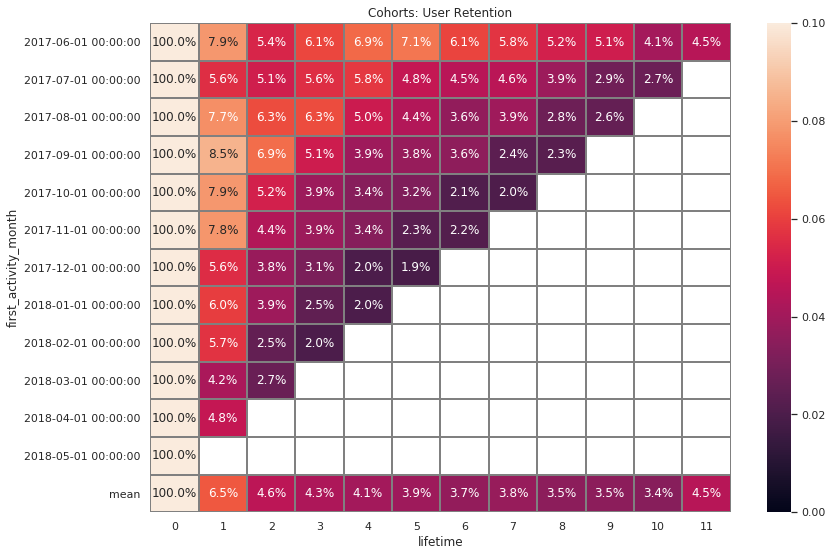

In [36]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, linewidths=1, linecolor='gray', fmt='.1%', vmin=0, vmax=0.1)
plt.show()

Видим, что сразу в первый месяц каждая когорта теряет больше 90% пользователей. К концу рассмариваемого периода "жизни" когорты пользователей остается чуть больше 2% от изначального кол-ва.

Посчитаем средний коэффициент удержания для второго месяца "жизни" когорты.

In [37]:
retention_2 = cohorts_lifetime[cohorts_lifetime['lifetime'] == 2]['retention'].mean()
retention_2 = (retention_2*100).round(2)
retention_2

4.63

Коэффициент удержания для второго месяца "жизни" когорты составил 4,63%.

### Метрики электронной коммерции

#### Среднее время между первым посещением и первым заказом

Посмотрим, сколько времени проходит с даты первого посещения сайта до первой даты покупки.

Строим таблицу по каждому пользователю с указаниме первой даты визита.

In [38]:
first_visits_date = visits.groupby('Uid')['Start Ts'].min()

Аналогично делаем с таблицей заказов - для каждого пользовтеля находим первую дату заказа.

In [39]:
first_order_date = orders.groupby('Uid')['Buy Ts'].min()
first_order_date.name = 'first_order_date'

Объединяем таблицу по id пользователя, и теперь у нас в распоряжении общая таблица, где для каждого пользователя указана дата первого посещения и дата первого заказа.

In [40]:
joined = pd.merge(first_visits_date, first_order_date, on='Uid')

In [41]:
joined

,Start Ts,first_order_date
Uid,,
313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...
18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00


In [42]:
#joined['Start Ts'] = joined['Start Ts'].astype('datetime64[M]')
#joined['first_order_date'] = joined['first_order_date'].astype('datetime64[M]')

Теперь рассчитываем разницу между датами посещений и заказа, и затем считаем среднее значение.

In [43]:
joined['time_beetwen'] = joined['first_order_date'] - joined['Start Ts']

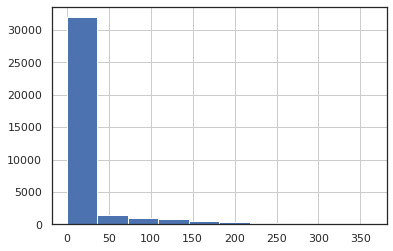

In [44]:
#joined['time_beetwen'].astype('int').hist()
joined['time_beetwen'].dt.days.hist()

In [45]:
avg_time = joined['time_beetwen'].dt.days.mode()

In [46]:
avg_time

0    0
dtype: int64

Получили, что в среднем первое посещение совпадает с первым заказом.

#### Среднее количество покупок на пользователя.

Присоединяем к таблице заказов таблицу с первым заказом.

In [47]:
orders_df = orders.join(first_order_date, on='Uid')
orders_df['first_order_month'] = orders_df['first_order_date'].astype('datetime64[M]')
orders_df['order_month'] = orders_df['Buy Ts'].astype('datetime64[M]')

In [48]:
orders_df

,Buy Ts,Revenue,Uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01
...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01


Создаем когорту уже по заказам, подсчитываем кол-во заказов и количество уникальных пользователей по когортам.

In [49]:
cohorts_1 = orders_df.groupby(['first_order_month', 'order_month'])['Uid'].agg(['count', 'nunique']).reset_index()
cohorts_1.head()

,first_order_month,order_month,count,nunique
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,61
2,2017-06-01,2017-08-01,174,50
3,2017-06-01,2017-09-01,226,54
4,2017-06-01,2017-10-01,292,88


Создаем столбец с временем "жизни" в этой таблице.

In [50]:
cohorts_1['age'] = (
    cohorts_1['order_month'] - cohorts_1['first_order_month']
) / np.timedelta64(1, 'M')
cohorts_1['age'] = cohorts_1['age'].round().astype('int')

In [51]:
cohorts_1

,first_order_month,order_month,count,nunique,age
0,2017-06-01,2017-06-01,2354,2023,0
1,2017-06-01,2017-07-01,177,61,1
2,2017-06-01,2017-08-01,174,50,2
3,2017-06-01,2017-09-01,226,54,3
4,2017-06-01,2017-10-01,292,88,4
...,...,...,...,...,...
74,2018-03-01,2018-05-01,176,58,2
75,2018-04-01,2018-04-01,2495,2276,0
76,2018-04-01,2018-05-01,195,69,1
77,2018-05-01,2018-05-01,3249,2988,0


Делаем столбец с количеством покупок на пользователя.

In [52]:
cohorts_1['purchase_per_user'] = cohorts_1['count']/cohorts_1['nunique']
cohorts_1.head()

,first_order_month,order_month,count,nunique,age,purchase_per_user
0,2017-06-01,2017-06-01,2354,2023,0,1.163618
1,2017-06-01,2017-07-01,177,61,1,2.901639
2,2017-06-01,2017-08-01,174,50,2,3.480000
3,2017-06-01,2017-09-01,226,54,3,4.185185
4,2017-06-01,2017-10-01,292,88,4,3.318182


Создаем сводную для удобства восприятия. И отобразим количество покупок на пользователя накопительным итогом.

In [53]:
output = cohorts_1.pivot_table(
    index='first_order_month', columns='age', values='purchase_per_user', aggfunc='mean'
)
output

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07-01,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08-01,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09-01,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10-01,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11-01,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


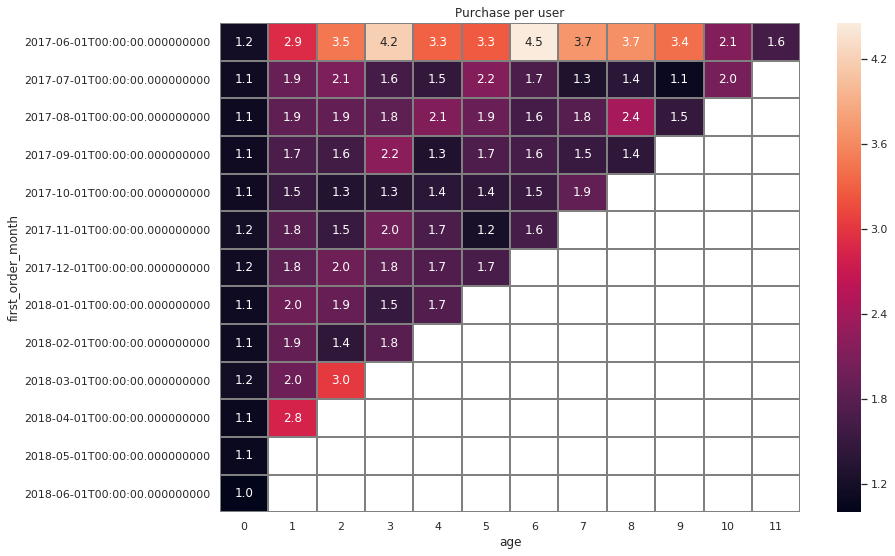

In [54]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Purchase per user')
sns.heatmap(output, annot=True, linewidths=1, linecolor='gray', fmt='.1f',)
plt.show()

Роста чилса покупок с течением "жизни" когоры не омечаем, самой положительной для нас когортой была июньская от 17го года, но рост ее количества покупок с 6го месяца жизни начал падать. При этом если в июне 2017 количество покупок на пользователя в нулевом месяце жизни когорты было 1.2, то в июне 2018 этот показатель равен уже ровно единице.

#### Средний чек

Создаем таблицу с групировкой по месяцам заказов, считаем сумму выручки внутри каждого месяца и количество уникальных пользователей. А потом делим выручку на количество пользователей и получаем значение среднего чека внутри каждого месяца заказа.

In [55]:
avg_orders = orders_df.groupby('order_month').agg({'Revenue': 'sum', 'Uid': 'nunique'}).reset_index()

In [56]:
avg_orders['revenue_per_user'] = avg_orders['Revenue']/avg_orders['Uid']

In [57]:
avg_orders

,order_month,Revenue,Uid,revenue_per_user
0,2017-06-01,9557.49,2023,4.724414
1,2017-07-01,12539.47,1984,6.320297
2,2017-08-01,8758.78,1472,5.950258
3,2017-09-01,18345.51,2750,6.671095
4,2017-10-01,27987.70,4675,5.986674
5,2017-11-01,27069.93,4547,5.953360
6,2017-12-01,36388.60,4942,7.363132
7,2018-01-01,19417.13,3898,4.981306
8,2018-02-01,25560.54,4258,6.002945
9,2018-03-01,28834.59,4181,6.896577


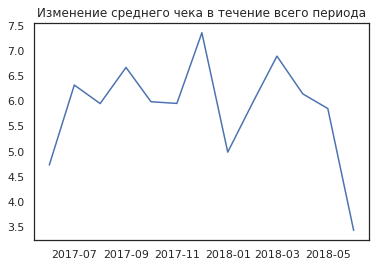

In [58]:
fig, ax = plt.subplots()
ax.plot(avg_orders['order_month'], avg_orders['revenue_per_user'])
plt.title('Изменение среднего чека в течение всего периода')
plt.show()

Максимальное значение среднего чека в 7.36 у.е. получено все в том же ноябре 2017 года. Однако почти сразу после пика идет падение значния среднего чека, и в январе он равен 4.98 у.е. В июне 2018 наблюдаем самый низкий средний чек в 3.42 у.е.

#### LTV

Посмотрим LTV - сумму денег, которую в среднем приносит один пользователь.

Добавляем в таблицу с затратами столбец месяца затрат.

In [59]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [60]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [61]:
orders_df.head()

,Buy Ts,Revenue,Uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Делаем таблицу с первой датой заказа, трансформируем ее в таблицу с первой датой заказа и количеством уникальных пользователей для каждой даты. Также делаем таблицу с группировкой по когортам заказов и для каждой когорты с разбивкой по месяцам внутри нее считаем общую выручку.

In [62]:
first_orders = orders_df.groupby('Uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'buyers']
cohorts_2 = orders_df.groupby(['first_order_month', 'order_month']).agg({'Revenue':'sum'}).reset_index()

Объединяем таблицы по первой дате заказа.

In [63]:
report_2 = pd.merge(cohort_sizes,cohorts_2,on='first_order_month')
report_2.head()

,first_order_month,buyers,order_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


Маржинальность сервиса 100%. Добавлем в полученную выше таблицу время "жизни" когорты. Считаем валовую прибыль через умножение выручки на маржинальность. И теперь можем рассчитать LTV через деление валовой прибыли на количество пользователей. Сводим полученную информацию, в строках указывая дату первого заказа, в столбцах возраст когорты, в значениях LTV. Оставим значения за 6 месяцев с июня 2017 по ноябрь 2017. И отобразим LTV.

In [64]:
margin_rate = 1
report_2['age'] = (report_2['order_month'] - report_2['first_order_month'])/np.timedelta64(1,'M') 
report_2['age'] = report_2['age'].round().astype('int')
report_2['gp'] =  report_2['Revenue']*margin_rate
report_2['ltv'] = report_2['gp'] / report_2['buyers']
result_2 = report_2.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
display(result_2)
result_3=result_2.loc['2017-06-01':'2017-11-01']
result_3=result_3.loc[:,[0,1,2,3,4,5]]
result_3

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.141820,0.161232,0.147145,0.155673,NaN
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664,0.405007,0.292212,0.187978,NaN,NaN
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608,0.243150,0.184006,NaN,NaN,NaN
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816,0.115470,NaN,NaN,NaN,NaN
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,0.260374,0.925097,1.065275,0.312930,0.338047,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.062698,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,0.278274,0.078515,0.074144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879


Считаем средний LTV для 6й когорты из полученной таблицы (накопительным итогом):

In [65]:
m6_cum_ltv = result_3.cumsum(axis=1).mean(axis=0)[5]
m6_cum_ltv

8.02390918500994

Т.е. пользователья 6й когорты в среднем принес нам 8.02 у.е. Построим тепловую карту для визуализации LTV.

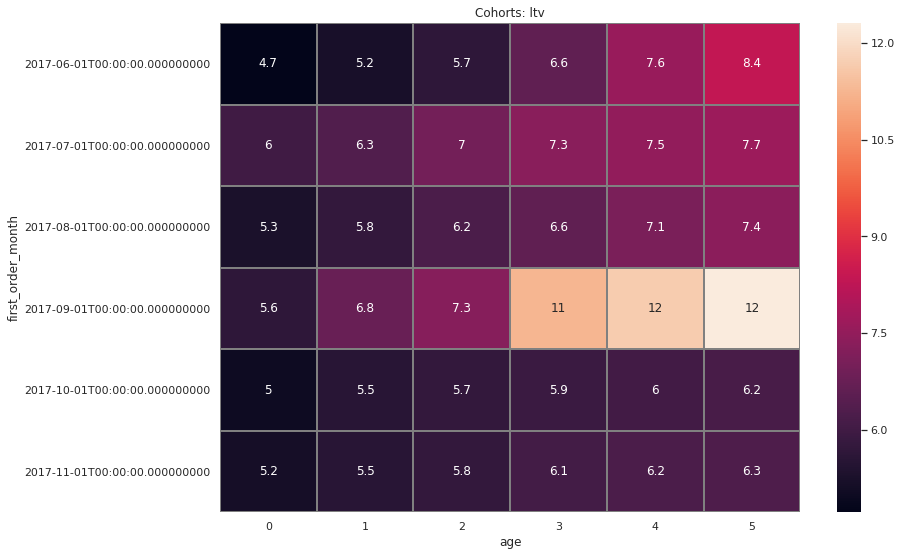

In [66]:
result_2_1=result_3.cumsum(axis=1).round(2)
plt.figure(figsize=(13, 9))
sns.set(style='white')
plt.title('Cohorts: ltv')
sns.heatmap(result_2_1, annot=True, linewidths=1, linecolor='gray')
plt.show()

Отмечаем 4ю когорту (сентябрь 17го), она демонстрирует сильный рост LTV, в отличие от другиех когорт, ее LTV с3го месяца жизни самый высокий.

### Маркетинговые метрики

#### Общая сумма расходов на маркетинг

Общие расходы на маркетинг равны:

In [67]:
costs['costs'].sum()

329131.62

Отразим распределение затрат по рекламным источникам.

In [68]:
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Видим, что самым затратным был источник 3. Посмотрим динамику затрат по месяцам.

In [69]:
costs['ad_month'] = costs['dt'].dt.strftime('%Y-%m')
costs.head()

,source_id,dt,costs,month,ad_month
0,1,2017-06-01,75.20,2017-06-01,2017-06
1,1,2017-06-02,62.25,2017-06-01,2017-06
2,1,2017-06-03,36.53,2017-06-01,2017-06
3,1,2017-06-04,55.00,2017-06-01,2017-06
4,1,2017-06-05,57.08,2017-06-01,2017-06


In [70]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 5 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
month        2542 non-null datetime64[ns]
ad_month     2542 non-null object
dtypes: datetime64[ns](2), float64(1), int64(1), object(1)
memory usage: 99.4+ KB


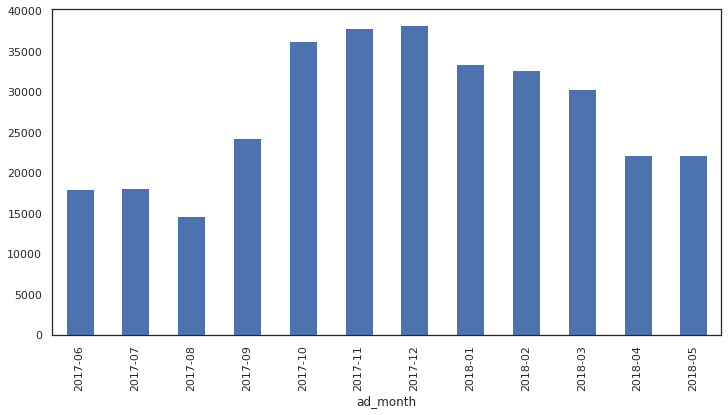

In [71]:
costs.groupby('ad_month')['costs'].sum().plot(kind='bar', figsize=(12,6))
plt.show()

Самые затратные месяцы были в ноябре-декабер 2017, что совпадает с пиками ранее расчитанных метрик. Изобразим график затрат за период по каждому источнику рекламы отдельно для визуализации.

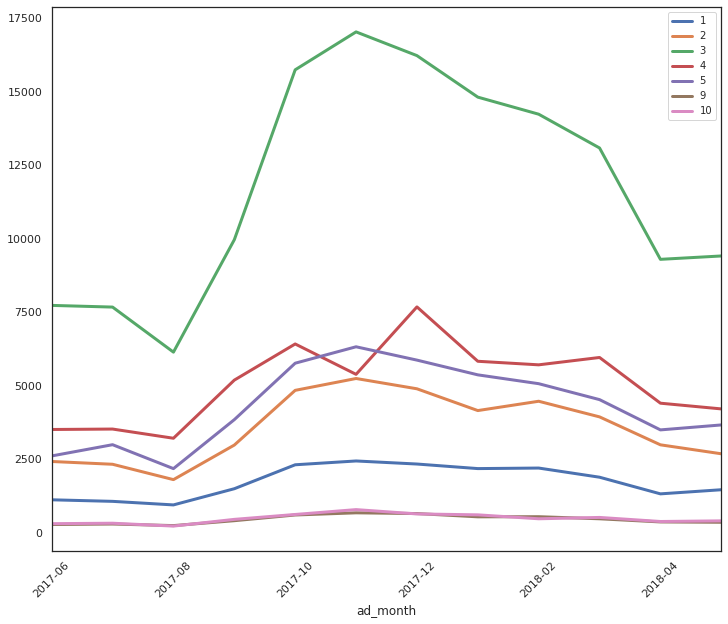

In [72]:
sources = costs['source_id'].unique()
for source in sources:
    costs[costs['source_id'] == source].groupby('ad_month')['costs'].sum().plot(figsize=(12,10), linewidth=3, rot=45)
plt.legend(sources, prop={'size':10})
plt.show()

#### CAC

Строим таблицу с суммой затрат по месяцам. Объединяем ее с таблицей, где собраны данные по валовой рибыли и LTV. Соединяем по месяцу рекламной кампании и месяцу первого заказа. Теперь у нас достаточно данных, чтобы расчитать показатель САС - сумма затрат на одного пользователя.

In [73]:
monthly_costs = costs.groupby('ad_month')['costs'].sum().reset_index()
monthly_costs['ad_month']=pd.to_datetime(monthly_costs['ad_month'])

In [74]:
report_2.head()

,first_order_month,buyers,order_month,Revenue,age,gp,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531


In [75]:
report_monthly_costs = pd.merge(report_2, monthly_costs, left_on='first_order_month', right_on='ad_month')
report_monthly_costs['cac'] = report_monthly_costs['costs'] / report_monthly_costs['buyers']
report_monthly_costs.head(10)

,first_order_month,buyers,order_month,Revenue,age,gp,ltv,ad_month,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,0,9557.49,4.724414,2017-06-01,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,1,981.82,0.485329,2017-06-01,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,2,885.34,0.437637,2017-06-01,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,3,1931.30,0.954671,2017-06-01,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,4,2068.58,1.022531,2017-06-01,18015.0,8.905091
5,2017-06-01,2023,2017-11-01,1487.92,5,1487.92,0.735502,2017-06-01,18015.0,8.905091
6,2017-06-01,2023,2017-12-01,1922.74,6,1922.74,0.950440,2017-06-01,18015.0,8.905091
7,2017-06-01,2023,2018-01-01,1176.56,7,1176.56,0.581592,2017-06-01,18015.0,8.905091
8,2017-06-01,2023,2018-02-01,1119.15,8,1119.15,0.553213,2017-06-01,18015.0,8.905091
9,2017-06-01,2023,2018-03-01,1225.51,9,1225.51,0.605788,2017-06-01,18015.0,8.905091


Считаем среднее значение САС:

In [76]:
report_monthly_costs['cac'].mean().round(2)

9.32

Т.е. в среднем на одного пользователя было потрачено 9.32 у.е.

Построим столбчатую гистограмму изменения во времени показателя САС.

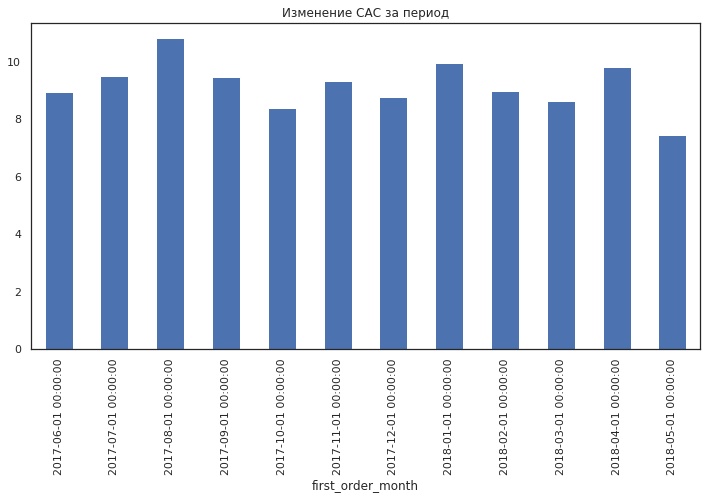

In [77]:
report_monthly_costs.groupby('first_order_month')['cac'].mean().plot(kind='bar', figsize=(12,6))
plt.title('Изменение САС за период')
plt.show()

Отмечаем, что дороже всего привлечение пользователя было в августе 2017, а также в январе и феврале 2018.

Посчитаем САС для каждого источника отдельно.

Строим таблицу с затратами по каждому источнику.

In [78]:
costs_by_source = costs.groupby('source_id')['costs'].sum().reset_index()

In [79]:
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Создаем таблицу с посещениями, где месяц первого заказа равен месяцам заказа.

In [81]:
vv = visits_df.rename(columns={'Start Ts':'visit_day'})

In [82]:
visits_by_source = vv.query('visit_day == first_activity_date').reset_index()

In [83]:
visits_by_source['first_activity_date'] = pd.to_datetime(visits_by_source['first_activity_date'])

In [84]:
visits_by_source['first_date'] = visits_by_source['first_activity_date']

In [85]:
orders_for_source = orders_df

In [86]:
orders_for_source['first_order_date'] = pd.to_datetime(orders_for_source['first_order_date'])
orders_for_source['first_date'] = orders_for_source['first_order_date']
visits_for_source = visits_by_source[['Source Id', 'Uid', 'first_date']]

In [87]:
visits_for_source

,Source Id,Uid,first_date
0,4,16879256277535980062,2017-12-20 17:20:00
1,2,104060357244891740,2018-02-19 16:53:00
2,5,7459035603376831527,2017-07-01 01:54:00
3,3,9969694820036681168,2017-12-27 14:06:00
4,5,16007536194108375387,2017-09-03 21:35:00
...,...,...,...
228165,2,18363291481961487539,2017-07-29 19:07:00
228166,1,18370831553019119586,2018-01-25 17:38:00
228167,4,18387297585500748294,2018-03-03 10:12:00
228168,5,18388616944624776485,2017-11-02 10:12:00


In [88]:
orders_for_source

,Buy Ts,Revenue,Uid,first_order_date,first_order_month,order_month,first_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,2017-06-01 07:58:00
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,2018-05-31 23:50:00
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,2018-05-31 23:50:00
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,2018-05-31 23:54:00
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,2018-05-31 23:56:00


In [89]:
source = pd.merge(visits_by_source, orders_for_source, on='Uid')

In [90]:
source

,index,Device,End Ts,Source Id,visit_day,Uid,year,month,date,week,...,first_activity_date,first_activity_month,lifetime,first_date_x,Buy Ts,Revenue,first_order_date,first_order_month,order_month,first_date_y
0,5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,2017-09-03,2017-08-31,...,2017-09-03 21:35:00,2017-09-01,0,2017-09-03 21:35:00,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,2017-09-01,2017-09-01,2017-09-04 12:46:00
1,5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,2017-09-03,2017-08-31,...,2017-09-03 21:35:00,2017-09-01,0,2017-09-03 21:35:00,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,2017-09-01,2017-10-01,2017-09-04 12:46:00
2,5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,2017-09-03,2017-08-31,...,2017-09-03 21:35:00,2017-09-01,0,2017-09-03 21:35:00,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,2017-09-01,2017-10-01,2017-09-04 12:46:00
3,27,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365,2017,2017-10-01,2017-10-23,2017-10-19,...,2017-10-23 12:49:00,2017-10-01,0,2017-10-23 12:49:00,2017-11-16 14:04:00,9.17,2017-11-16 14:04:00,2017-11-01,2017-11-01,2017-11-16 14:04:00
4,27,desktop,2017-10-23 12:58:00,3,2017-10-23 12:49:00,4499746016005494365,2017,2017-10-01,2017-10-23,2017-10-19,...,2017-10-23 12:49:00,2017-10-01,0,2017-10-23 12:49:00,2017-11-16 23:39:00,4.28,2017-11-16 14:04:00,2017-11-01,2017-11-01,2017-11-16 14:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,2018-01-01,2018-01-25,2018-01-25,...,2018-01-25 17:38:00,2018-01-01,0,2018-01-25 17:38:00,2018-01-25 17:38:00,2.93,2018-01-25 17:38:00,2018-01-01,2018-01-01,2018-01-25 17:38:00
50411,359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,2018-01-01,2018-01-25,2018-01-25,...,2018-01-25 17:38:00,2018-01-01,0,2018-01-25 17:38:00,2018-01-25 22:29:00,0.37,2018-01-25 17:38:00,2018-01-01,2018-01-01,2018-01-25 17:38:00
50412,359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,2018-03-01,2018-03-03,2018-03-01,...,2018-03-03 10:12:00,2018-03-01,0,2018-03-03 10:12:00,2018-03-03 10:12:00,0.61,2018-03-03 10:12:00,2018-03-01,2018-03-01,2018-03-03 10:12:00
50413,359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,2017-11-01,2017-11-02,2017-11-02,...,2017-11-02 10:12:00,2017-11-01,0,2017-11-02 10:12:00,2017-11-02 10:12:00,2.69,2017-11-02 10:12:00,2017-11-01,2017-11-01,2017-11-02 10:12:00


In [91]:
source = source.groupby('Source Id').agg({'Uid':'nunique'}).reset_index()

In [92]:
source = source.rename(columns={'Source Id':'source_id'})

In [93]:
source

,source_id,Uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [94]:
cac = costs_by_source.merge(source, on='source_id', how='outer')
cac=cac.fillna(0)

In [95]:
cac

,source_id,costs,Uid
0,1,20833.27,2899
1,2,42806.04,3506
2,3,141321.63,10473
3,4,61073.60,10296
4,5,51757.10,6931
5,9,5517.49,1088
6,10,5822.49,1329
7,7,0.00,1


In [96]:
cac['cac'] = cac['costs'] / cac['Uid']

In [97]:
cac

,source_id,costs,Uid,cac
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106
7,7,0.00,1,0.000000


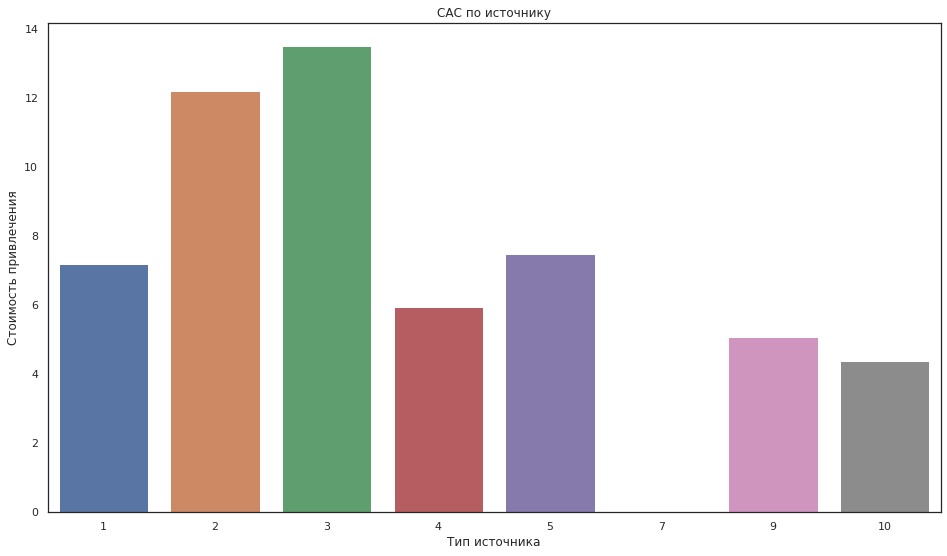

In [98]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('CAC по источнику')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Стоимость привлечения')
plt.show()

Видим, что самые большие затраты на привлечение одного пользователя были у источника 3, затем по затратности идет источник 2, при этом на 7й источник затрат не было вообще.

#### ROMI

In [99]:
vv_1 = visits_df.rename(columns={'Start Ts':'visit_day'})

In [100]:
vv_1 = vv_1.query('visit_day == first_activity_date').reset_index()

In [101]:
vv_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228170 entries, 0 to 228169
Data columns (total 14 columns):
index                   228170 non-null int64
Device                  228170 non-null object
End Ts                  228170 non-null datetime64[ns]
Source Id               228170 non-null int64
visit_day               228170 non-null datetime64[ns]
Uid                     228170 non-null uint64
year                    228170 non-null int64
month                   228170 non-null datetime64[ns]
date                    228170 non-null datetime64[ns]
week                    228170 non-null datetime64[ns]
session_duration_sec    228170 non-null int64
first_activity_date     228170 non-null datetime64[ns]
first_activity_month    228170 non-null datetime64[ns]
lifetime                228170 non-null int64
dtypes: datetime64[ns](7), int64(5), object(1), uint64(1)
memory usage: 24.4+ MB


In [102]:
vv_2=vv_1[['Uid','Source Id']]

In [103]:
vv_2.duplicated().sum()

1

In [104]:
vv_2=vv_2.drop_duplicates()

In [105]:
vv_2.duplicated().sum()

0

Создаем таблицу с первой датой заказа по пользователю, присоединяем ее к таблице заказов. Для удобства переименовываем столбцы, тоже самое делаем с таблицей посещений.

In [106]:
orders_new = orders.reset_index()
orders_new['Buy_date'] = orders_new['Buy Ts'].dt.strftime('%Y-%m-%d')
orders_new['Buy_date'] = pd.to_datetime(orders_new['Buy_date'])
min_order_datetime = orders_new.groupby(['Uid'])['Buy_date'].min()
min_order_datetime.name = 'min_order_datetime'
orders_new = orders_new.join(min_order_datetime, on='Uid')
orders_new['first_order_month'] = orders_new['min_order_datetime'].dt.strftime('%Y-%m')
orders_new['order_month'] = orders_new['Buy_date'].dt.strftime('%Y-%m')
orders_new['day']=orders_new['Buy_date']

In [107]:
orders_new.head()

,index,Buy Ts,Revenue,Uid,Buy_date,min_order_datetime,first_order_month,order_month,day
0,0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06,2017-06,2017-06-01
1,1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06,2017-06,2017-06-01
2,2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06,2017-06,2017-06-01
3,3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06,2017-06,2017-06-01
4,4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06,2017-06,2017-06-01


In [108]:
source_orders = pd.merge(vv_2, orders_new, on='Uid')

In [109]:
source_orders.head()

,Uid,Source Id,index,Buy Ts,Revenue,Buy_date,min_order_datetime,first_order_month,order_month,day
0,16007536194108375387,5,6788,2017-09-04 12:46:00,2.44,2017-09-04,2017-09-04,2017-09,2017-09,2017-09-04
1,16007536194108375387,5,14979,2017-10-28 00:01:00,1.53,2017-10-28,2017-09-04,2017-09,2017-10,2017-10-28
2,16007536194108375387,5,15068,2017-10-28 19:16:00,1.53,2017-10-28,2017-09-04,2017-09,2017-10,2017-10-28
3,4499746016005494365,3,17866,2017-11-16 14:04:00,9.17,2017-11-16,2017-11-16,2017-11,2017-11,2017-11-16
4,4499746016005494365,3,17979,2017-11-16 23:39:00,4.28,2017-11-16,2017-11-16,2017-11,2017-11,2017-11-16


In [110]:
monthly_costs

,ad_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


In [111]:
def romi_per_source(source):
    print('Код источника:', source)
    one=source_orders[source_orders['Source Id']==source]
    cohort_sizes_one = one.groupby('first_order_month').agg({'Uid':'nunique'}).reset_index()
    cohort_sizes_one.columns = ['first_order_month', 'buyers']
    cohorts_one = one.groupby(['first_order_month', 'order_month']).agg({'Revenue':'sum'}).reset_index()
    report_one = pd.merge(cohort_sizes_one,cohorts_one,on='first_order_month')
    report_one['first_order_month']=report_one['first_order_month'].astype('datetime64[M]')
    report_one['order_month']=report_one['order_month'].astype('datetime64[M]')
    report_one['age'] = (report_one['order_month']-report_one['first_order_month'])/np.timedelta64(1,'M') 
    report_one['age'] = report_one['age'].round().astype('int')
    report_one['gp'] =  report_one['Revenue']*margin_rate
    report_one['ltv'] = report_one['gp'] / report_one['buyers']
    report_one=pd.merge(report_one, monthly_costs, left_on='first_order_month', right_on='ad_month')
    report_one['cac'] = report_monthly_costs['costs'] / report_monthly_costs['buyers']
    report_one['romi'] = report_one['ltv']/report_one['cac']
    output = report_one.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
    output_heatmap = output.cumsum(axis=1).fillna(0)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Накопительный ROMI источника')
    sns.heatmap(output_heatmap, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    plt.show()
    print(output.cumsum(axis=1).mean(axis=0))

Код источника: 1


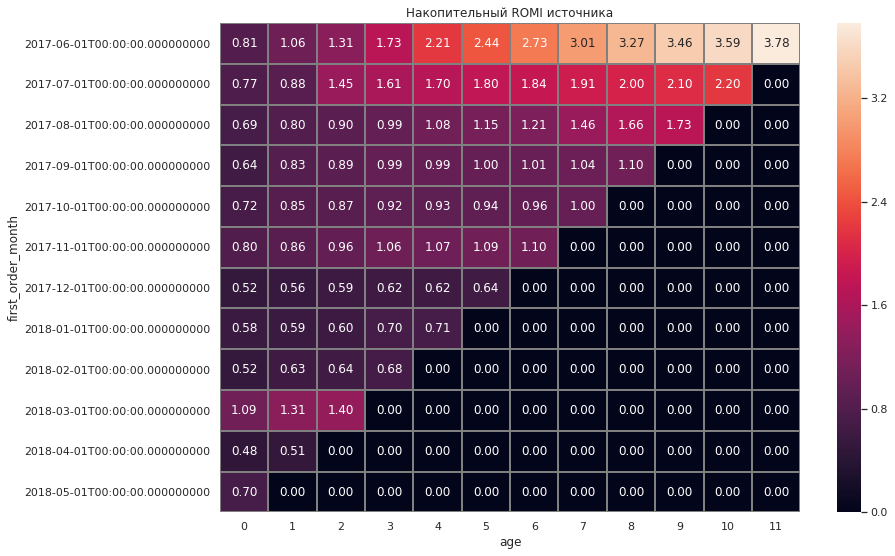

age
0     0.693744
1     0.807493
2     0.961942
3     1.032833
4     1.164732
5     1.291835
6     1.474555
7     1.684110
8     2.007590
9     2.430023
10    2.896434
11    3.778081
dtype: float64
Код источника: 2


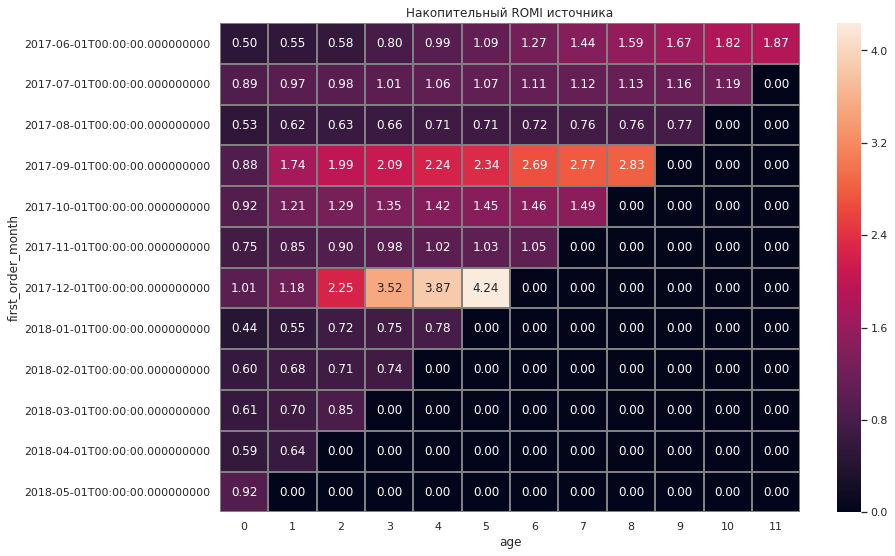

age
0     0.719818
1     0.880643
2     1.090271
3     1.322101
4     1.508616
5     1.705142
6     1.383445
7     1.516299
8     1.577566
9     1.198811
10    1.508595
11    1.870916
dtype: float64
Код источника: 3


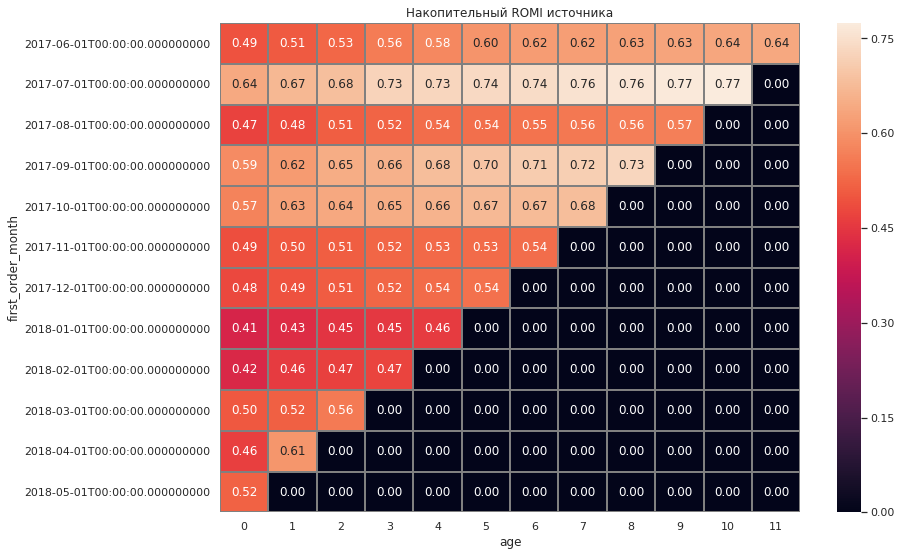

age
0     0.504697
1     0.537609
2     0.550430
3     0.565803
4     0.589716
5     0.618122
6     0.638033
7     0.666694
8     0.671133
9     0.656977
10    0.705774
11    0.640738
dtype: float64
Код источника: 4


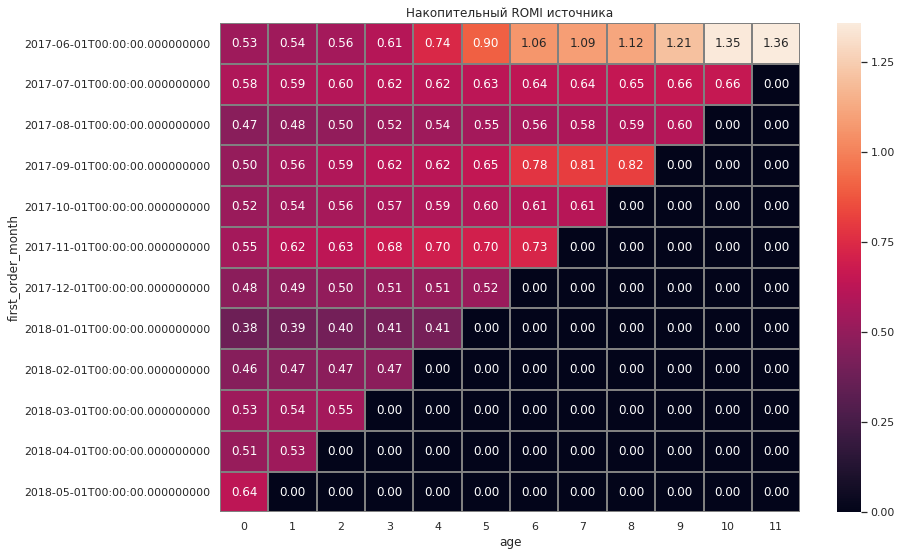

age
0     0.513445
1     0.523188
2     0.535705
3     0.556151
4     0.590847
5     0.651298
6     0.730518
7     0.748021
8     0.793349
9     0.821672
10    1.005009
11    1.357514
dtype: float64
Код источника: 5


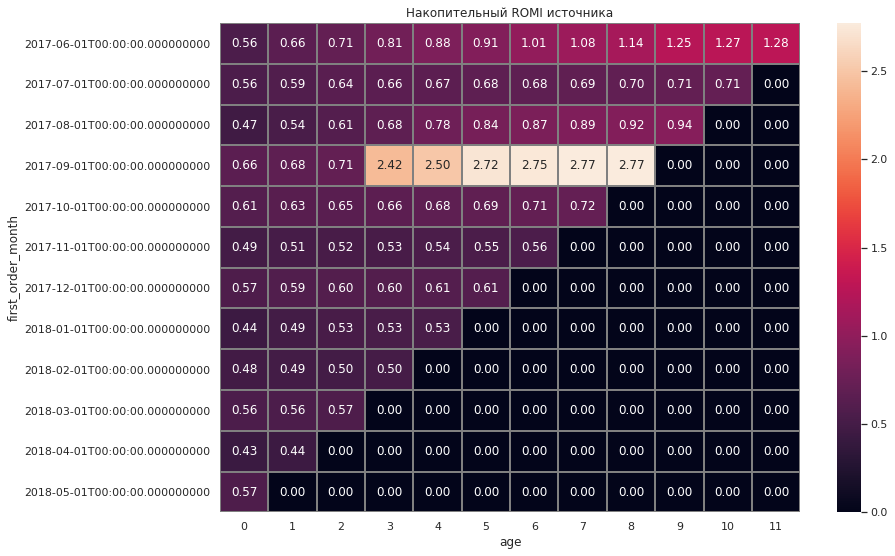

age
0     0.531777
1     0.561456
2     0.603837
3     0.821431
4     0.899251
5     0.998543
6     1.096756
7     1.231336
8     1.383049
9     0.964681
10    0.990919
11    1.280178
dtype: float64
Код источника: 9


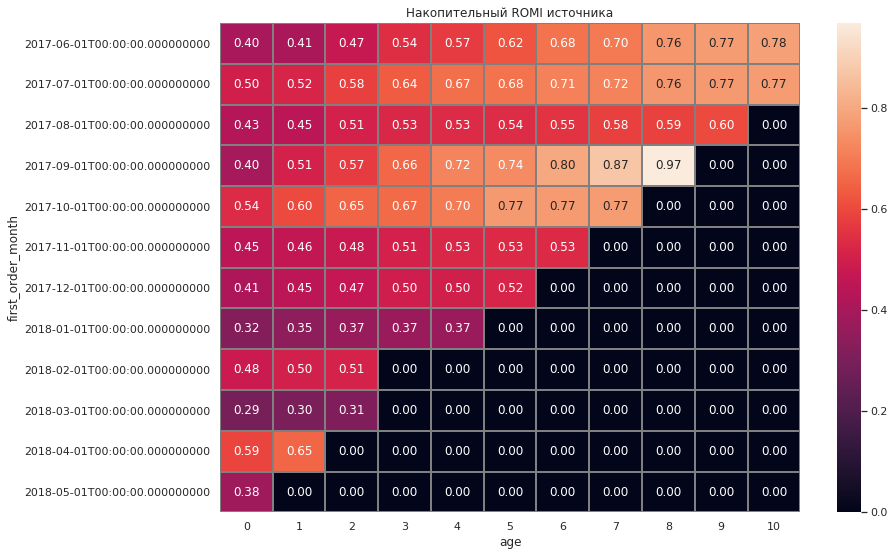

age
0     0.432970
1     0.472383
2     0.492733
3     0.551351
4     0.575461
5     0.627443
6     0.674427
7     0.726963
8     0.768426
9     0.712301
10    0.776403
dtype: float64
Код источника: 10


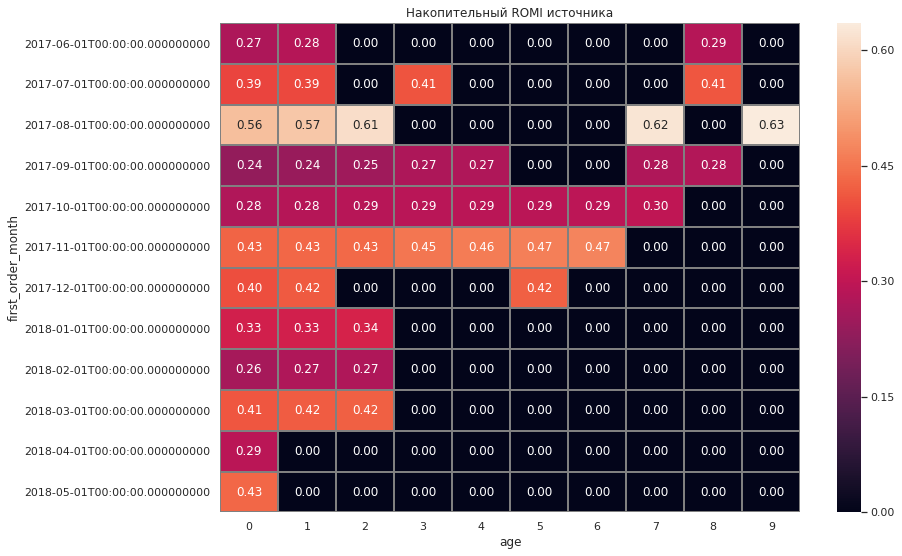

age
0    0.357319
1    0.364870
2    0.373774
3    0.354844
4    0.342204
5    0.393346
6    0.382810
7    0.399596
8    0.324271
9    0.634954
dtype: float64


In [112]:
for source in sources:
    romi_per_source(source)

Самый быстрый по окупаемости источник это второй, он окупается на второй месяц жизни когорты, также хорошая динамика окупаемости у 1го источника, он окупился на третий месяц. 3й, 9й, 10й источники не окупаются вовсе. При этом выше мы видели, что на 3й истоник потрачено больше всего средств. Когорты 10го истоника самые не долговечные.

## Выводы:

Ежемесячное количество посетителей сайта от июня 2017 до ноября 2017 росло с 10000 человек до 30000, после пика показтель пошел на спад, но не упал ниже 25000 человек в месяц. Ежедневно на сайт приходит в среднем 1000 человек. Один пользовател заходит на сайт раз в день, при этом к июню 2018 средний показатель посещения сайта упал до ровно 1. Среднее время посещения сайта - 1 минута. С июня 2017 по апрель 2018 отмечался рост числа новых пользователей, однако после апреля их сичло существенно упало. К концу периода с нами осталось около 2% пользователей, и лишь в когорте июня 2017 коэффициент удержания в конце периода составил 4.5%. Среднее количество покупок на одного пользователя также снизилось к концу периода, если в июне 2017 этот показатель был 1.2, то в конце периода стал равен 1. Обычно пользователь делает покупку в первый день своего визита на сайт. Отмечаем снижение дохода от одного пользователя с течением времени. По затратам вперед вышел третий рекламный источник, однако по окупаемости он оказался на последнем месте, что вызывает вопросы к его эффективности. Определенно стоит продолжать работу с 1,2 и 5 источником, их окупаемость в течение всего периода хорошо растет. Также стоит отказаться от 10 источника рекламы, он не окупает себя, кроме того пользователи, пришедшие благодаря ему, не остаются с нами надолго.